In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm 

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/data and weights/sensor_final.csv')

In [ ]:
df.shape

(119103, 24)

In [ ]:
df.head()

,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,...,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
0,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,...,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834
1,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,...,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834
2,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,...,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963
3,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,...,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028
4,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,...,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093


In [ ]:
df.columns

Index(['sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05',
       'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49'],
      dtype='object')

In [ ]:
n_in = 10  

n_out = 10

val_size = 10

test_size = 5

In [ ]:
def lstm_train_data_transform(df, n_in, n_out,val_size,test_size):
    
  """ Changes data to the format for LSTM training 
        for sliding window approach """    
    
  encoder_input, final_output = list(), list()         # Prepare the list for the transformed data
  
  for i in range(df.shape[0]):                    # Loop of the entire data set
        
    total_steps = i + n_in + n_out
        
    if total_steps >= df.shape[0]:               # if index is larger than the size of the dataset, we stop
        
      break        
        
    end_enc_inp = i + n_in                       # compute a new (sliding window) index for encoder input
            
    final_out_end = end_enc_inp + n_out
    
    seq_enc_input = df[i:end_enc_inp]                    # Get a sequence of data for x
            
    seq_final_out = df[end_enc_inp:final_out_end]
    
    encoder_input.append(seq_enc_input)                             # Append the list with sequencies
            
    final_output.append(seq_final_out)
    
  encoder_input = np.array(encoder_input)                           # Make final arrays
      
  final_output = np.array(final_output)
      
  train_size = round(( encoder_input.shape[0] * (val_size + test_size) ) / 100)
      
  train_size = encoder_input.shape[0] - train_size
  
  val_size = round((encoder_input.shape[0] * val_size) / 100)
  
  val_size = train_size + val_size
      
  encoder_input_train = encoder_input[:train_size]
      
  final_output_train = final_output[:train_size]
  
  encoder_input_val = encoder_input[train_size:val_size]
      
  final_output_val = final_output[train_size:val_size]
  
  encoder_input_test = encoder_input[val_size:]
      
  final_output_test = final_output[val_size:]
  
  return encoder_input_train, final_output_train, encoder_input_val, final_output_val, encoder_input_test, final_output_test

In [ ]:
encoder_input_train, final_output_train, encoder_input_val, final_output_val, encoder_input_test, final_output_test = lstm_train_data_transform(df,n_in,n_out,val_size,test_size)

In [ ]:
print(encoder_input_train.shape, final_output_train.shape, encoder_input_val.shape, final_output_val.shape, encoder_input_test.shape, final_output_test.shape)

(101221, 10, 24) (101221, 10, 24) (11908, 10, 24) (11908, 10, 24) (5954, 10, 24) (5954, 10, 24)


In [ ]:
encoder_input_train[0]

array([[ 47.09201   ,  53.2118    ,  46.31076   , 634.375     ,
         76.45975   ,  13.41146   ,  16.13136   ,  15.56713   ,
         15.05353   ,  37.2274    ,  47.52422   ,  31.11716   ,
          1.681353  ,  31.51042   ,  70.57291   ,  30.98958   ,
         31.77083206,  41.92708   ,  39.6412    ,  65.68287   ,
         50.92593   ,  38.19444   , 157.9861    ,  67.70834   ],
       [ 47.09201   ,  53.2118    ,  46.31076   , 634.375     ,
         76.45975   ,  13.41146   ,  16.13136   ,  15.56713   ,
         15.05353   ,  37.2274    ,  47.52422   ,  31.11716   ,
          1.681353  ,  31.51042   ,  70.57291   ,  30.98958   ,
         31.77083206,  41.92708   ,  39.6412    ,  65.68287   ,
         50.92593   ,  38.19444   , 157.9861    ,  67.70834   ],
       [ 47.35243   ,  53.2118    ,  46.39757   , 638.8889    ,
         73.54598   ,  13.32465   ,  16.03733   ,  15.61777   ,
         15.01013   ,  37.86777   ,  48.17723   ,  32.08894   ,
          1.708474  ,  31.25      ,  6

In [ ]:
final_output_train[0]

array([[ 47.48264   ,  53.125     ,  46.39756775, 637.7314    ,
         76.05148   ,  13.41146   ,  16.16753   ,  15.65393   ,
         15.11863   ,  39.90199   ,  50.48941   ,  32.80076   ,
          1.678884  ,  32.55208   ,  75.52083   ,  30.98958   ,
         31.51041603,  41.40625   ,  39.35185   ,  54.97685   ,
         50.92593   ,  39.35185   , 190.9722    ,  71.18056   ],
       [ 47.91666   ,  53.1684    ,  46.39756775, 635.6482    ,
         74.58654   ,  13.41146   ,  16.16753   ,  15.84925   ,
         15.11863   ,  39.78521   ,  50.7882    ,  33.14559   ,
          1.62582   ,  32.29166   ,  78.125     ,  30.46875   ,
         31.51041603,  41.66666   ,  39.35185242,  53.81944   ,
         51.21528   ,  39.0625    , 193.5764    ,  72.33796   ],
       [ 48.26389   ,  53.125     ,  46.39756775, 630.0926    ,
         76.95988   ,  13.34635   ,  16.16753   ,  15.73351   ,
         15.01013   ,  40.04284   ,  50.50479   ,  33.46326   ,
          1.641763  ,  31.77083   ,  7

SCALING

In [ ]:
historical_max = np.expand_dims(np.max(encoder_input_train.reshape(-1, encoder_input_train.shape[-1]),axis=0,keepdims=True),0)

In [ ]:
historical_max

array([[[ 55.77257,  56.03299,  48.22049, 671.9907 ,  99.98649,
          21.39034,  23.50984,  19.29253,  18.98871,  76.10686,
          60.     ,  45.     ,  31.18755, 547.9166 , 512.7604 ,
         219.0104 , 330.4688 , 302.0833 , 221.0648 , 220.1968 ,
         320.8912 , 196.7593 , 474.8264 , 241.3194 ]]])

In [ ]:
historical_min = np.expand_dims(np.min(encoder_input_train.reshape(-1, encoder_input_train.shape[-1]),axis=0,keepdims=True),0)

In [ ]:
historical_min

array([[[2.24392400e+01, 3.73263900e+01, 3.32899300e+01, 3.10474500e+00,
         0.00000000e+00, 1.44675900e-02, 0.00000000e+00, 2.89351800e-02,
         7.23379600e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.31770800e+01, 3.02083300e+01, 2.39583300e+01,
         2.57812500e+01, 2.89062500e+01, 2.86458300e+01, 2.89351800e+01,
         3.06712971e+01, 3.09606476e+01, 3.03819400e+01, 3.00925900e+01]]])

In [ ]:
scaler = StandardScaler()

encoder_input_train = scaler.fit_transform(encoder_input_train.reshape(-1, encoder_input_train.shape[-1])).reshape(encoder_input_train.shape)

final_output_train = scaler.transform(final_output_train.reshape(-1, final_output_train.shape[-1])).reshape(final_output_train.shape)

encoder_input_val = scaler.transform(encoder_input_val.reshape(-1, encoder_input_val.shape[-1])).reshape(encoder_input_val.shape)

final_output_val = scaler.transform(final_output_val.reshape(-1, final_output_val.shape[-1])).reshape(final_output_val.shape)

In [ ]:
encoder_input_train[0]

array([[-0.54627295,  0.57271204,  1.36901975,  0.21392975,  0.07215851,
         0.10999412,  0.20147399,  0.41478212,  0.12168474, -0.67434818,
         0.67617788,  0.17247415, -0.4594733 , -0.42283275,  0.25457603,
        -0.66111523, -0.50192887, -0.18998437, -0.15557582,  2.30410195,
         0.45439314, -0.63257224,  0.61341908,  1.00940349],
       [-0.54627295,  0.57271204,  1.36901975,  0.21392975,  0.07215851,
         0.10999412,  0.20147399,  0.41478212,  0.12168474, -0.67434818,
         0.67617788,  0.17247415, -0.4594733 , -0.42283275,  0.25457603,
        -0.66111523, -0.50192887, -0.18998437, -0.15557582,  2.30410195,
         0.45439314, -0.63257224,  0.61341908,  1.00940349],
       [-0.41238784,  0.57271204,  1.41747626,  0.28344541, -0.1690718 ,
         0.01073595,  0.07736012,  0.48931037,  0.05796156, -0.59303942,
         0.75320263,  0.29619865, -0.45282175, -0.4419021 ,  0.19554877,
        -0.72451575, -0.50192911, -0.21836249, -0.19634307,  2.27533548,
  

In [ ]:
final_output_train[0]

array([[-0.34544529,  0.52933959,  1.417475  ,  0.2656195 ,  0.03835793,
         0.10999412,  0.24921619,  0.54252802,  0.21726953, -0.3347514 ,
         1.02593215,  0.38682572, -0.46007884, -0.34655681,  0.53495751,
        -0.66111523, -0.53236461, -0.24673952, -0.19634341,  1.23973543,
         0.45439314, -0.49247271,  1.18890305,  1.27803456],
       [-0.1223103 ,  0.55102581,  1.417475  ,  0.23353748, -0.08292409,
         0.10999412,  0.24921619,  0.82998573,  0.21726953, -0.34957913,
         1.06117545,  0.43072857, -0.47309303, -0.36562616,  0.6825268 ,
        -0.72451575, -0.53236461, -0.21836249, -0.19634307,  1.12466854,
         0.47888831, -0.52749729,  1.23433659,  1.36757773],
       [ 0.0562049 ,  0.52933959,  1.417475  ,  0.14797928,  0.11356415,
         0.03554763,  0.24921619,  0.65964805,  0.05796156, -0.31686746,
         1.02774627,  0.47117349, -0.46918294, -0.40376413,  0.71204043,
        -0.72451598, -0.53236461, -0.1048511 , -0.19634341,  1.06713559,
  

CHECKPOINTS

In [ ]:
#callbacks

filepath = '/content/drive/My Drive/data and weights/option_3/b'

filepath = filepath + "/model-{epoch:02d}.hdf5"

checkpoint_cb = ModelCheckpoint(filepath=filepath,monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

lr_cb = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.001,verbose=1)

es_cp = EarlyStopping(monitor='val_loss', patience=5)

cb = [checkpoint_cb, lr_cb, es_cp]

MODELLING

In [ ]:
batch_size = 64  # Batch size for training.

epochs = 100  # Number of epochs to train for.

units = 256  # no of lstm units

features = 24

In [ ]:
# Define an input sequence and process it.

input = Input(shape=(n_in,features))

lstm1 = LSTM(units, return_sequences=True, return_state=True, dtype='float64')

lstm1_output, hidden, cell = lstm1(input)

states = [hidden, cell]

lstm2 = LSTM(units, return_sequences=True, dtype='float64')

lstm2_output = lstm2(lstm1_output, initial_state=states)

lstm2_dense = Dense(features, dtype='float64')

lstm2_output = lstm2_dense(lstm2_output)

model = Model(input, lstm2_output)

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 24)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 10, 256),    287744      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  (None, 10, 256)      525312      ['lstm[0][0]',                   
                                                                  'lstm[0][1]',               

In [ ]:
model.fit(
    x = encoder_input_train,
    y = final_output_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(encoder_input_val,final_output_val),
    callbacks=cb
)

Epoch 1/100
1582/1582 [==============================] - ETA: 0s - loss: 0.1500
Epoch 1: val_loss improved from inf to 2.95915, saving model to /content/drive/My Drive/data and weights/option_3/b/model-01.hdf5
1582/1582 [==============================] - 48s 25ms/step - loss: 0.1500 - val_loss: 2.9592 - lr: 0.0010
Epoch 2/100
1581/1582 [============================>.] - ETA: 0s - loss: 0.0927
Epoch 2: val_loss improved from 2.95915 to 2.81275, saving model to /content/drive/My Drive/data and weights/option_3/b/model-02.hdf5
1582/1582 [==============================] - 37s 24ms/step - loss: 0.0928 - val_loss: 2.8127 - lr: 0.0010
Epoch 3/100
1581/1582 [============================>.] - ETA: 0s - loss: 0.0826
Epoch 3: val_loss did not improve from 2.81275
1582/1582 [==============================] - 37s 24ms/step - loss: 0.0826 - val_loss: 3.0439 - lr: 0.0010
Epoch 4/100
1582/1582 [==============================] - ETA: 0s - loss: 0.0765
Epoch 4: val_loss did not improve from 2.81275
1582

INFERENCE

In [ ]:
def inference(input):
  
  input = scaler.transform(input)
        
  input = tf.expand_dims(input,0)
          
  pred = model_new.predict(input,verbose = 0)
      
  pred = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1])).reshape(pred.shape)
  
  for i in range(pred.shape[1]):
    
    for j in range(pred.shape[2]):
      
      if pred[:,i,j] < historical_min[0][0][j]:
        
        pred[:,i,j] = historical_min[0][0][j]
            
      elif pred[:,i,j] > historical_max[0][0][j]:
            
        pred[:,i,j] = historical_max[0][0][j]
                
  return pred          

PERFORMANCE ON UNSEEN DATA

In [ ]:
## loading saved model
model_new = load_model(r'/content/drive/My Drive/data and weights/option_3/b/model-02.hdf5')

In [ ]:
model_new

In [ ]:
model_new.layers

In [ ]:
eg_in = encoder_input_test[-100].copy()   #random input

eg_in

array([[ 45.18229   ,  51.38889   ,  46.70139   , 625.1157    ,
         91.20374   ,  13.5923    ,  16.16753   ,  14.98843   ,
         15.11863   ,  42.85203   ,  42.33655   ,  31.43786   ,
          0.9422286 ,  47.13541   ,  64.32291   ,  40.10416   ,
         36.97916   ,  40.88541   ,  37.61574   ,  37.90509   ,
         42.53472   ,  44.56018   , 150.1736    ,  46.29629517],
       [ 45.18229   ,  51.38889   ,  46.7013855 , 638.1945    ,
         92.38508   ,  13.614     ,  16.16753   ,  15.33565   ,
         15.08247   ,  43.18192   ,  39.49083   ,  30.0829    ,
          0.9266053 ,  45.83333   ,  61.19791   ,  39.58333   ,
         36.97916412,  40.625     ,  37.61574173,  37.90509   ,
         41.95602   ,  43.69213   , 146.7014    ,  46.2963    ],
       [ 45.22569   ,  51.43229   ,  46.7013855 , 626.8518    ,
         91.54748   ,  13.65017   ,  16.21094   ,  15.18374   ,
         15.11863   ,  46.2267    ,  44.85515   ,  30.92017   ,
          0.9036457 ,  44.01041   ,  6

In [ ]:
eg_out = final_output_test[-100].copy()

eg_out

array([[ 45.18228912,  51.47569   ,  46.7013855 , 632.7546    ,
         95.04433   ,  13.49826   ,  16.16753   ,  15.45139   ,
         15.05353   ,  46.53951   ,  46.15298   ,  31.72707   ,
          0.8674103 ,  47.39583   ,  55.72916   ,  52.60416   ,
         38.80208   ,  40.625     ,  39.0625    ,  37.61574   ,
         44.56018   ,  60.76389   , 131.3657    ,  46.58564758],
       [ 45.18229   ,  51.43229   ,  46.7013855 , 643.8657    ,
         93.14604   ,  13.67911   ,  16.16753   ,  15.49479   ,
         15.05353   ,  45.95877   ,  46.59649   ,  32.66118   ,
          0.8790819 ,  46.09375   ,  54.42708   ,  50.78125   ,
         38.28125   ,  40.10416   ,  41.95602   ,  37.90509   ,
         44.8495369 ,  61.34259   , 125.8681    ,  46.58564758],
       [ 45.22569   ,  51.43229   ,  46.7013855 , 624.537     ,
         94.75258   ,  13.614     ,  16.2037    ,  14.90885   ,
         15.05353   ,  45.67464   ,  42.96502   ,  31.59706   ,
          0.8468108 ,  44.79166   ,  5

In [ ]:
pred_out = inference(eg_in)

pred_out

array([[[ 45.41643597,  51.37056668,  46.23561901, 627.10945062,
          94.72874652,  13.57936195,  16.126682  ,  15.31431385,
          15.04640175,  48.65682821,  44.50636343,  31.36860631,
           1.20134107,  47.3992335 ,  60.46410454,  53.68857831,
          39.25997922,  40.07493209,  38.83860191,  39.02972666,
          43.22544593,  60.51263117, 126.41122003,  45.99160085],
        [ 45.53297642,  51.37383776,  46.20101573, 631.46769424,
          94.04426157,  13.65805786,  16.16328736,  15.33004291,
          15.06878747,  48.56608241,  44.30585074,  31.87947092,
           1.40012049,  45.68703875,  59.6331827 ,  51.37022903,
          38.84318063,  40.42294701,  40.02919557,  39.3876859 ,
          42.39593588,  61.45058425, 125.0804244 ,  46.24463695],
        [ 45.60568284,  51.34694779,  46.14001935, 633.22578128,
          93.32217869,  13.69535978,  16.16420035,  15.34211473,
          15.07838497,  48.52930939,  44.22550988,  32.29702497,
           1.53366924, 

In [ ]:
mean_squared_error(eg_out, pred_out.reshape(-1,pred_out.shape[-1]),squared=False)

2.679647766981476

In [ ]:
pred = []

for i in tqdm(range(encoder_input_test.shape[0])):
    
    x = encoder_input_test[i].copy()
        
    x = inference(x)
    
    pred.append(x)
    
pred = np.concatenate(pred,0)

100%|██████████| 5954/5954 [07:23<00:00, 13.42it/s]


In [ ]:
pred.shape

(5954, 10, 24)

Total rmse

In [ ]:
mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1]), pred.reshape(-1,pred.shape[-1]),squared=False)

4.90516473422126

Total rmse f1

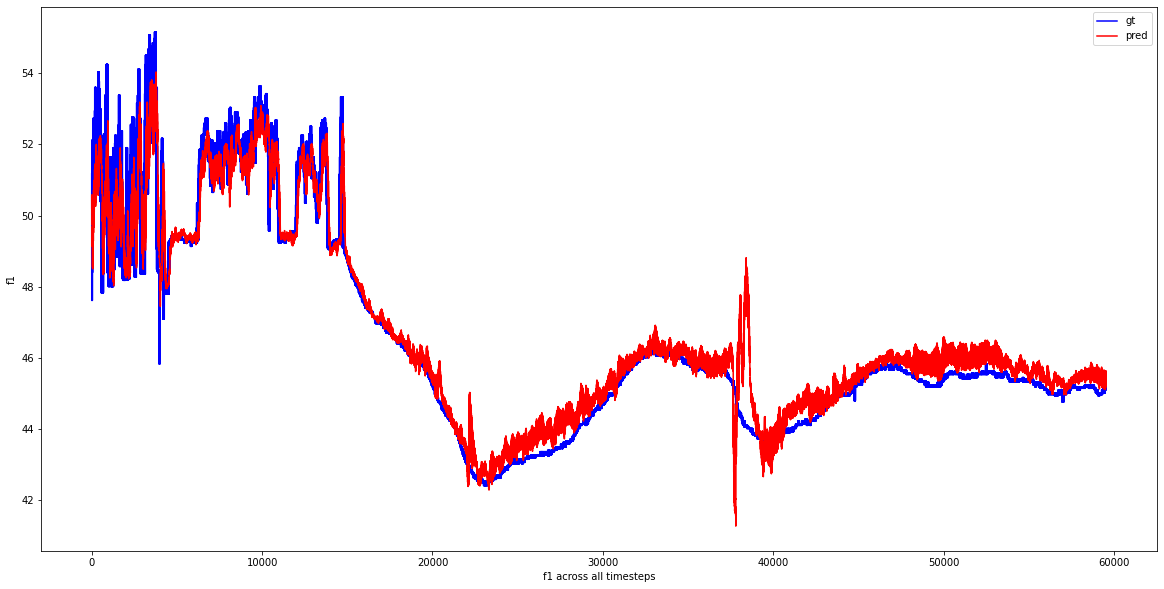

0.7793059464990433


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,0], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,0],c='red', label="pred")

plt.legend()

plt.xlabel('f1 across all timesteps')

plt.ylabel('f1')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,0], pred.reshape(-1,pred.shape[-1])[:,0],squared=False))

Total rmse f2

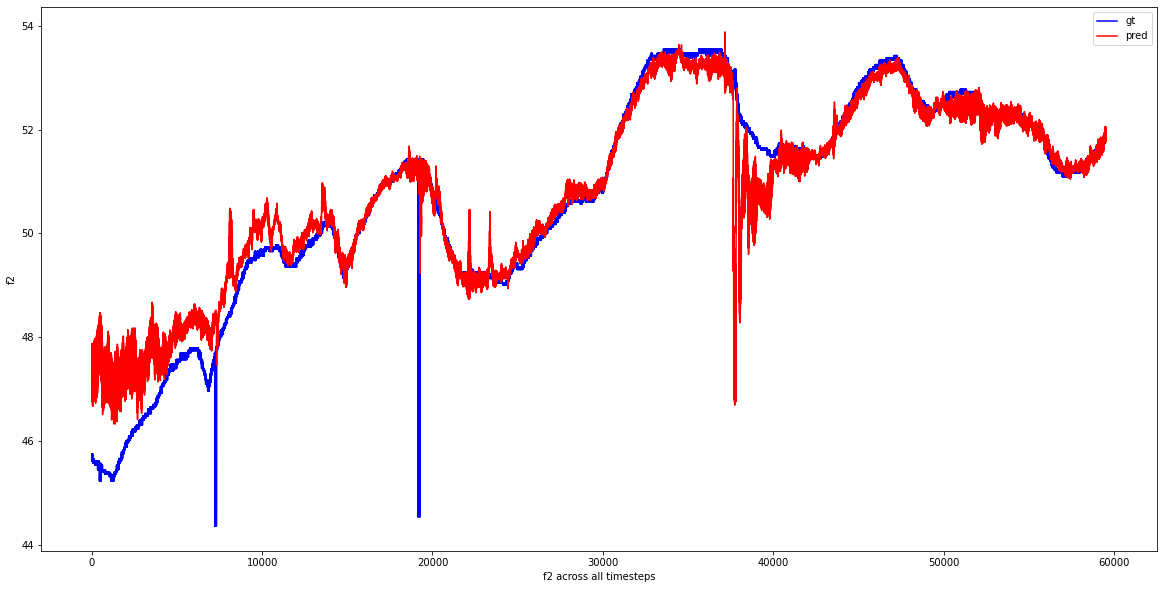

0.662668694250643


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,1], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,1],c='red', label="pred")

plt.legend()

plt.xlabel('f2 across all timesteps')

plt.ylabel('f2')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,1], pred.reshape(-1,pred.shape[-1])[:,1],squared=False))

Total rmse f3

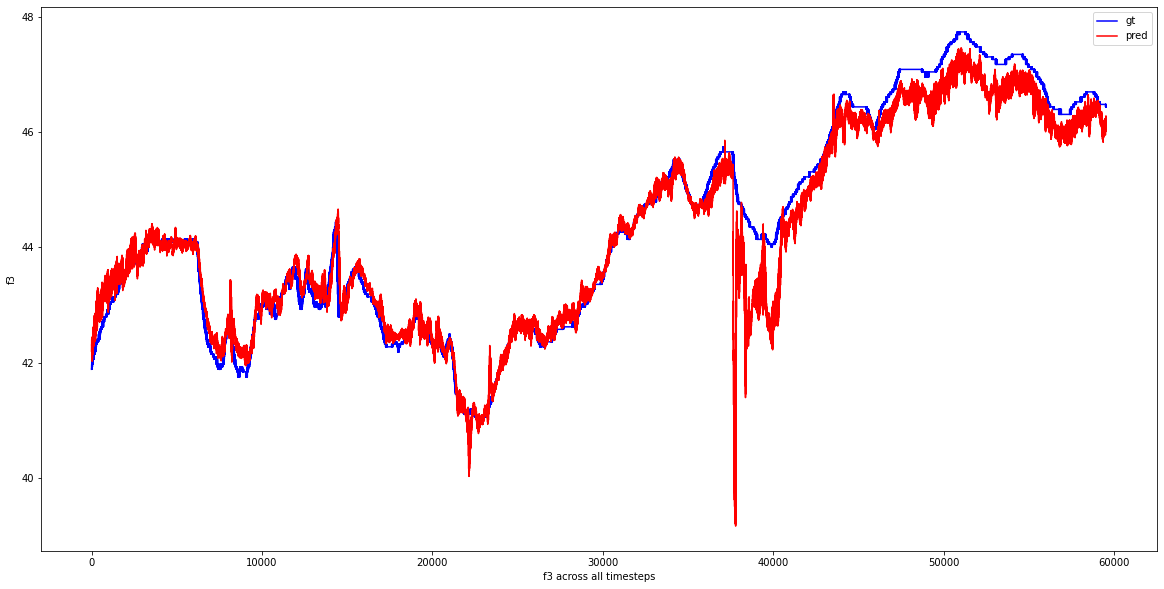

0.48016206398743067


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,2], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,2],c='red', label="pred")

plt.legend()

plt.xlabel('f3 across all timesteps')

plt.ylabel('f3')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,2], pred.reshape(-1,pred.shape[-1])[:,2],squared=False))

Total rmse f4

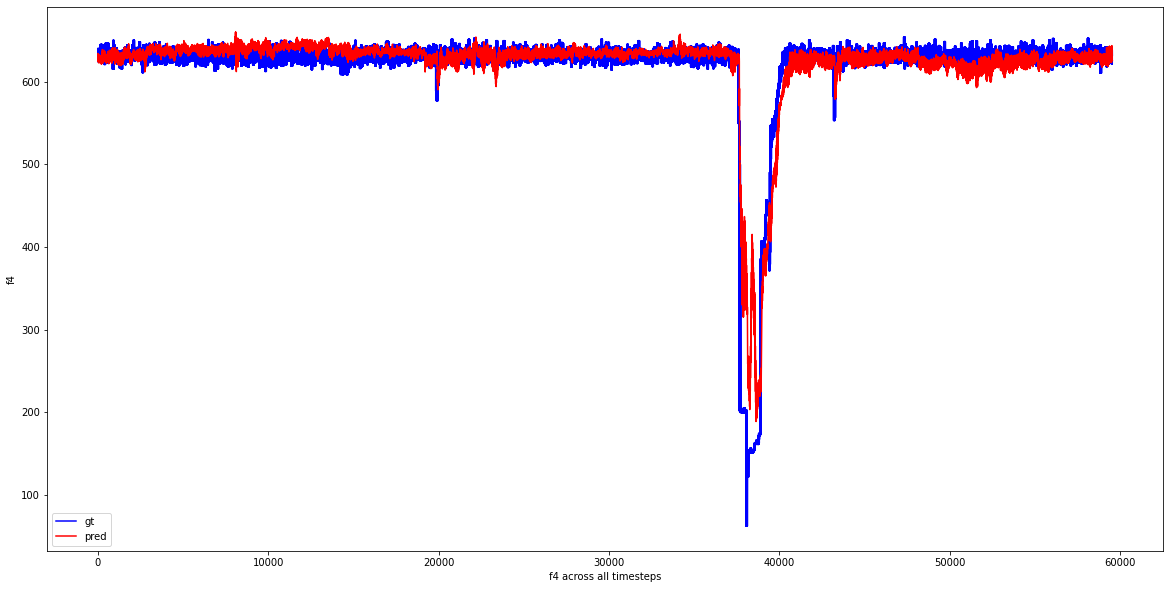

27.211090387986363


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,3], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,3],c='red', label="pred")

plt.legend()

plt.xlabel('f4 across all timesteps')

plt.ylabel('f4')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,3], pred.reshape(-1,pred.shape[-1])[:,3],squared=False))

Total rmse f5

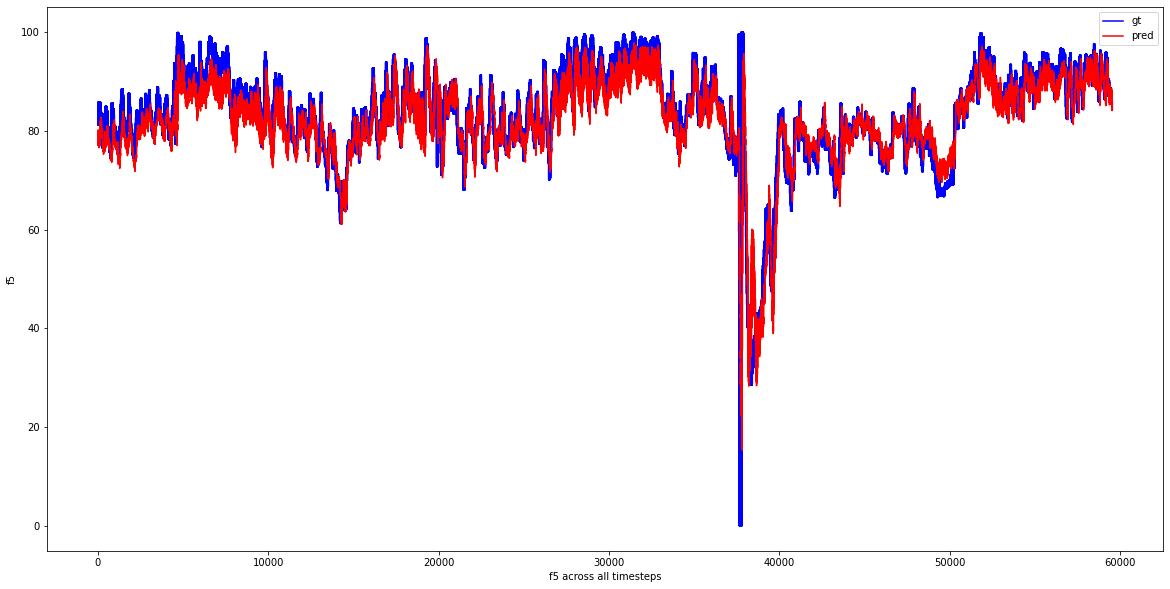

5.457509028634942


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,4], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,4],c='red', label="pred")

plt.legend()

plt.xlabel('f5 across all timesteps')

plt.ylabel('f5')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,4], pred.reshape(-1,pred.shape[-1])[:,4],squared=False))

Total rmse f6

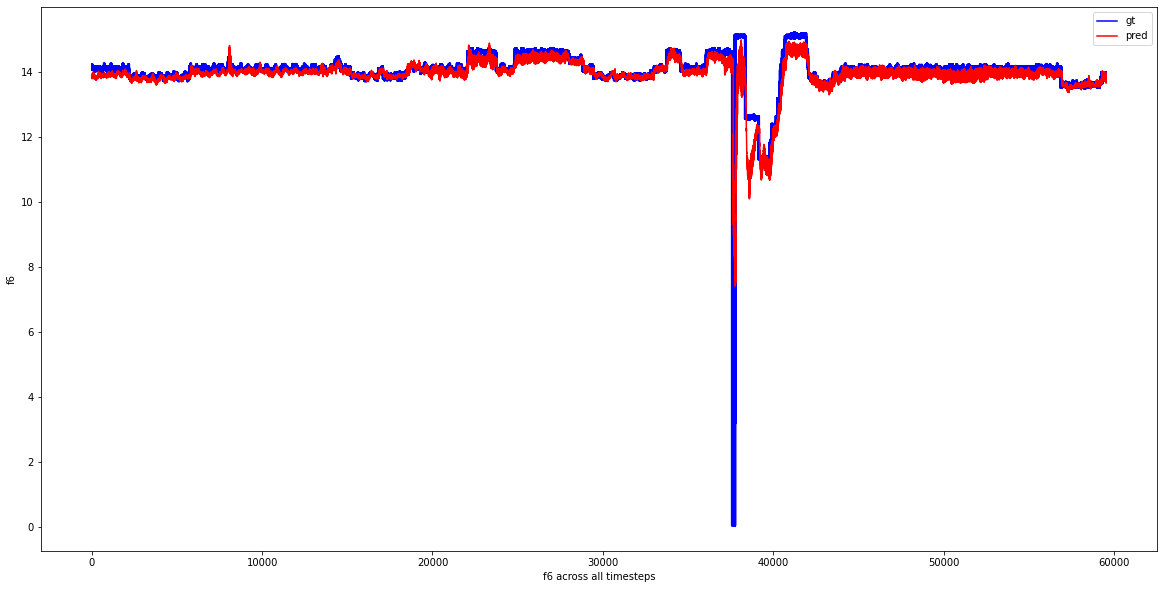

0.6862391606457237


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,5], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,5],c='red', label="pred")

plt.legend()

plt.xlabel('f6 across all timesteps')

plt.ylabel('f6')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,5], pred.reshape(-1,pred.shape[-1])[:,5],squared=False))

Total rmse f7

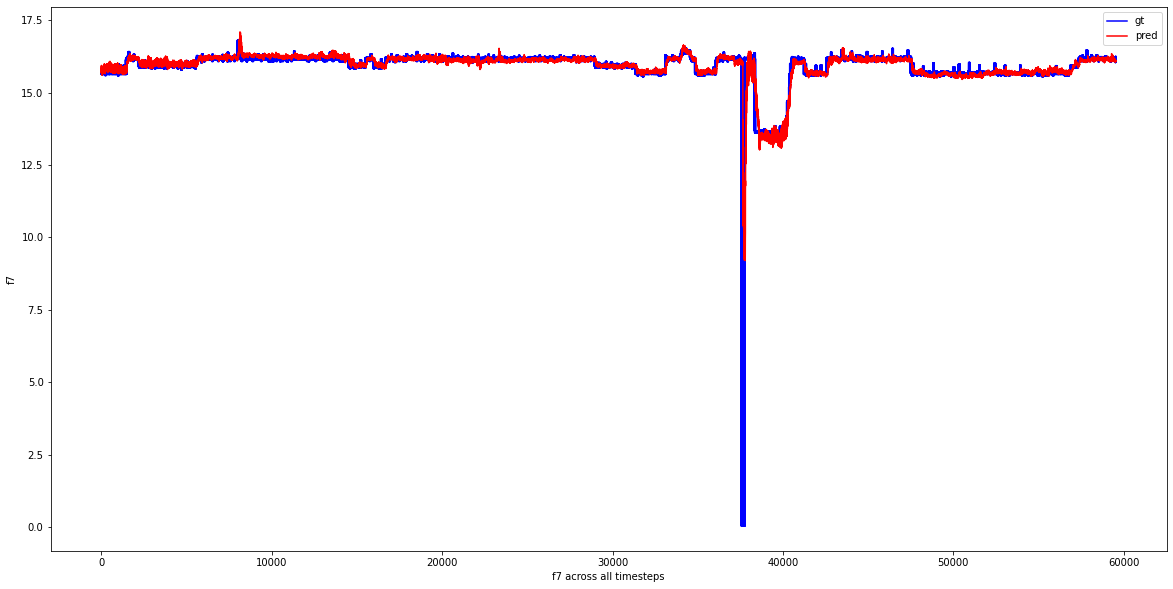

0.702124161508105


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,6], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,6],c='red', label="pred")

plt.legend()

plt.xlabel('f7 across all timesteps')

plt.ylabel('f7')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,6], pred.reshape(-1,pred.shape[-1])[:,6],squared=False))

Total rmse f8

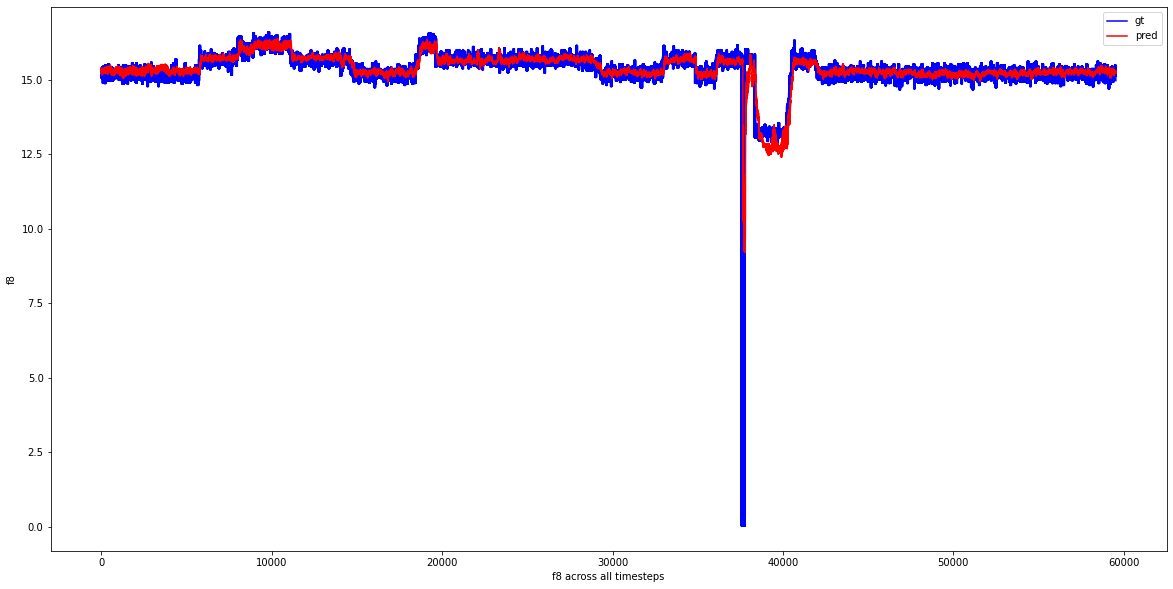

0.7083443396683273


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,7], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,7],c='red', label="pred")

plt.legend()

plt.xlabel('f8 across all timesteps')

plt.ylabel('f8')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,7], pred.reshape(-1,pred.shape[-1])[:,7],squared=False))

Total rmse f9

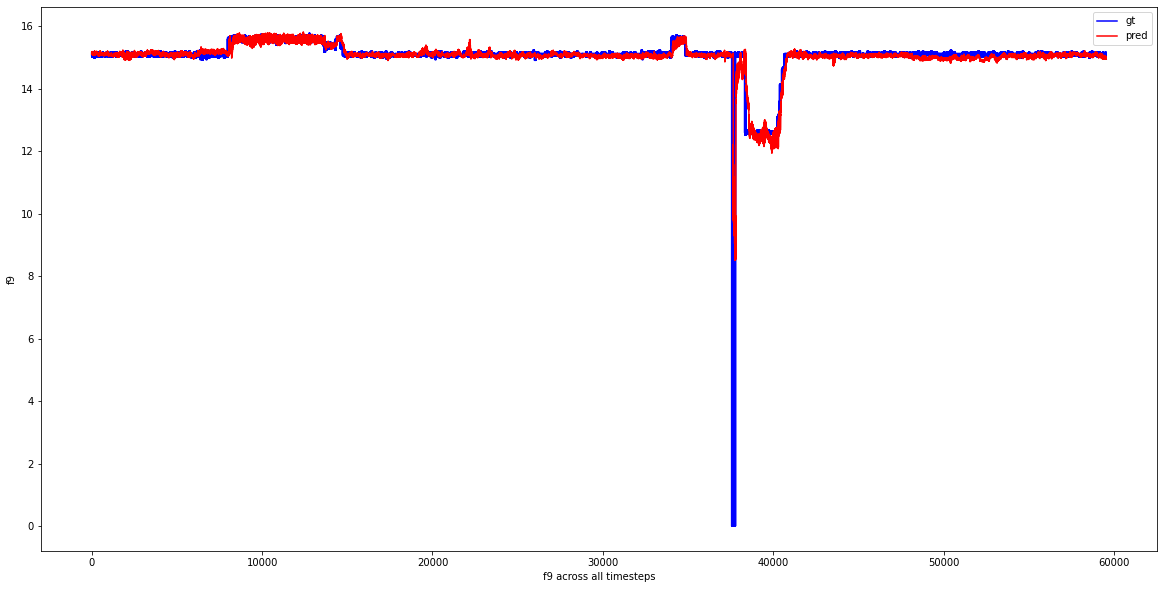

0.6503343739636978


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,8], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,8],c='red', label="pred")

plt.legend()

plt.xlabel('f9 across all timesteps')

plt.ylabel('f9')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,8], pred.reshape(-1,pred.shape[-1])[:,8],squared=False))

Total rmse f10

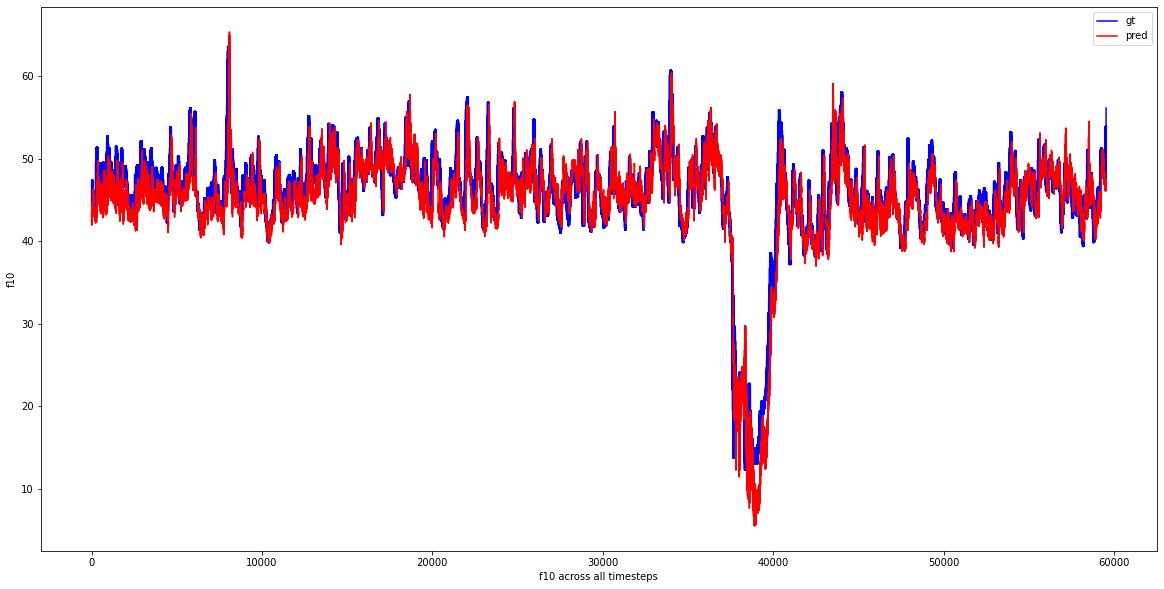

2.97889814474468


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,9], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,9],c='red', label="pred")

plt.legend()

plt.xlabel('f10 across all timesteps')

plt.ylabel('f10')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,9], pred.reshape(-1,pred.shape[-1])[:,9],squared=False))

Total rmse f11

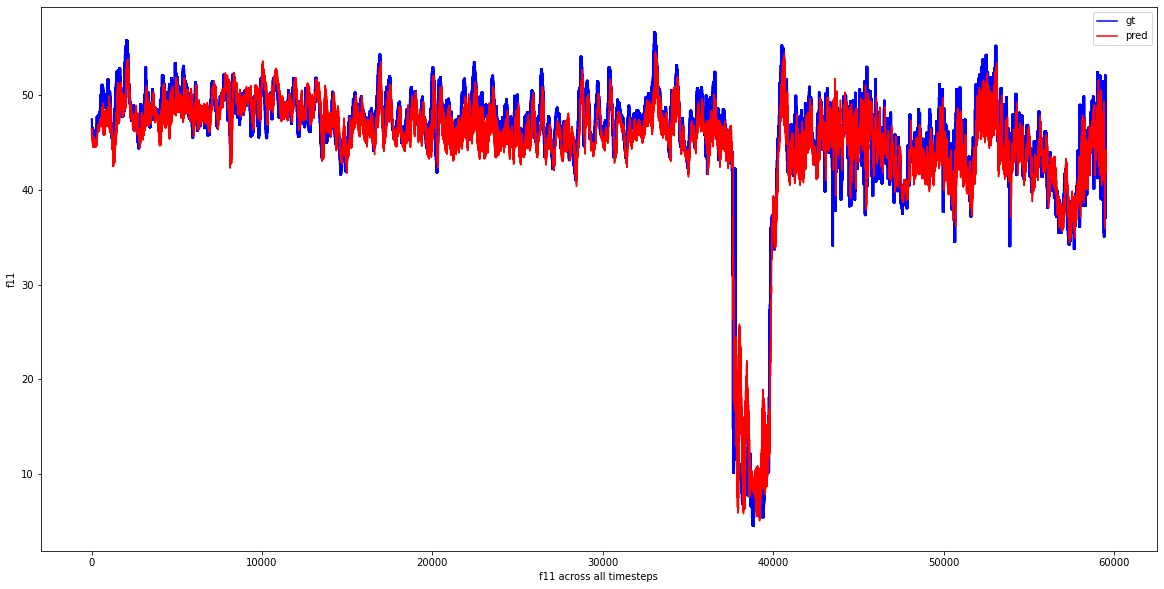

2.741386258575333


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,10], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,10],c='red', label="pred")

plt.legend()

plt.xlabel('f11 across all timesteps')

plt.ylabel('f11')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,10], pred.reshape(-1,pred.shape[-1])[:,10],squared=False))

Total rmse f12

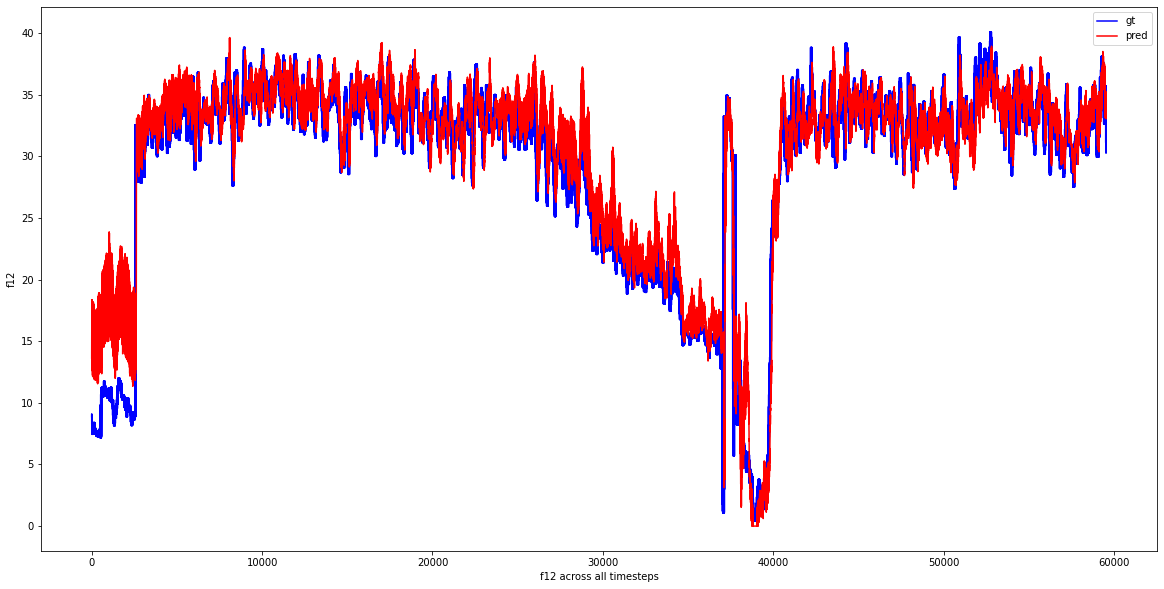

3.008740767298006


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,11], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,11],c='red', label="pred")

plt.legend()

plt.xlabel('f12 across all timesteps')

plt.ylabel('f12')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,11], pred.reshape(-1,pred.shape[-1])[:,11],squared=False))

Total rmse f13

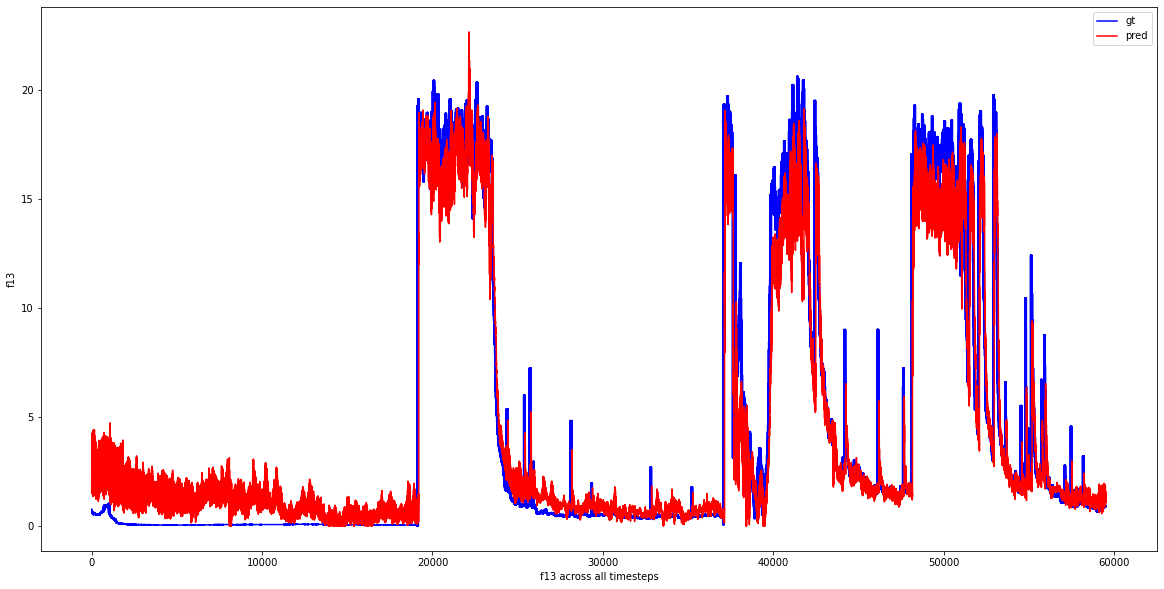

2.057790852087755


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,12], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,12],c='red', label="pred")

plt.legend()

plt.xlabel('f13 across all timesteps')

plt.ylabel('f13')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,12], pred.reshape(-1,pred.shape[-1])[:,12],squared=False))

Total rmse f14

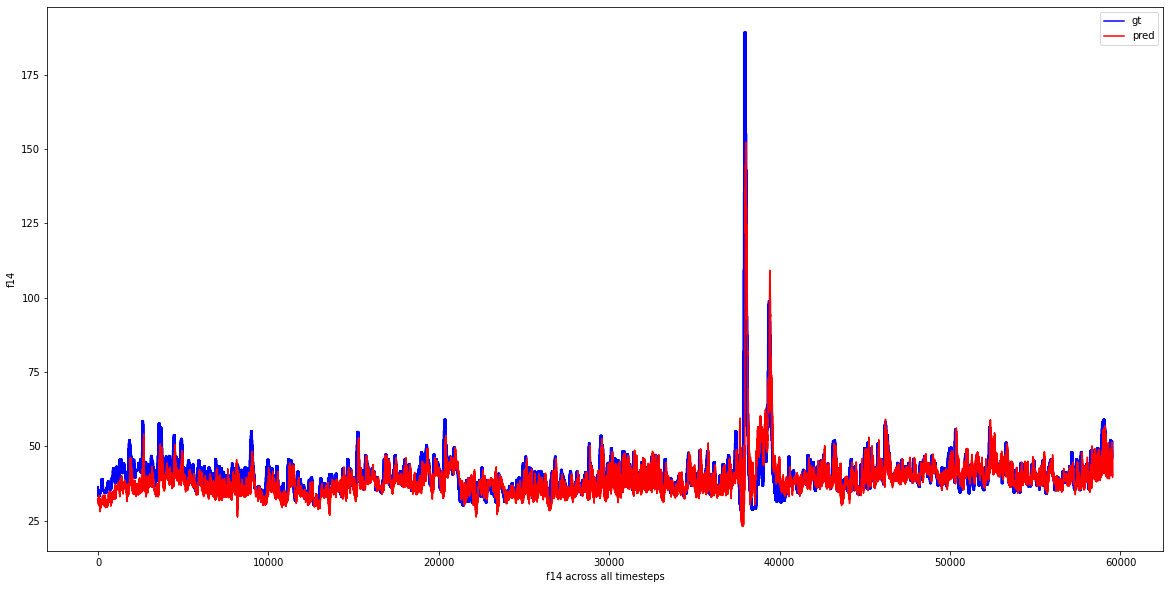

6.073773047708019


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,13], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,13],c='red', label="pred")

plt.legend()

plt.xlabel('f14 across all timesteps')

plt.ylabel('f14')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,13], pred.reshape(-1,pred.shape[-1])[:,13],squared=False))

Total rmse f15

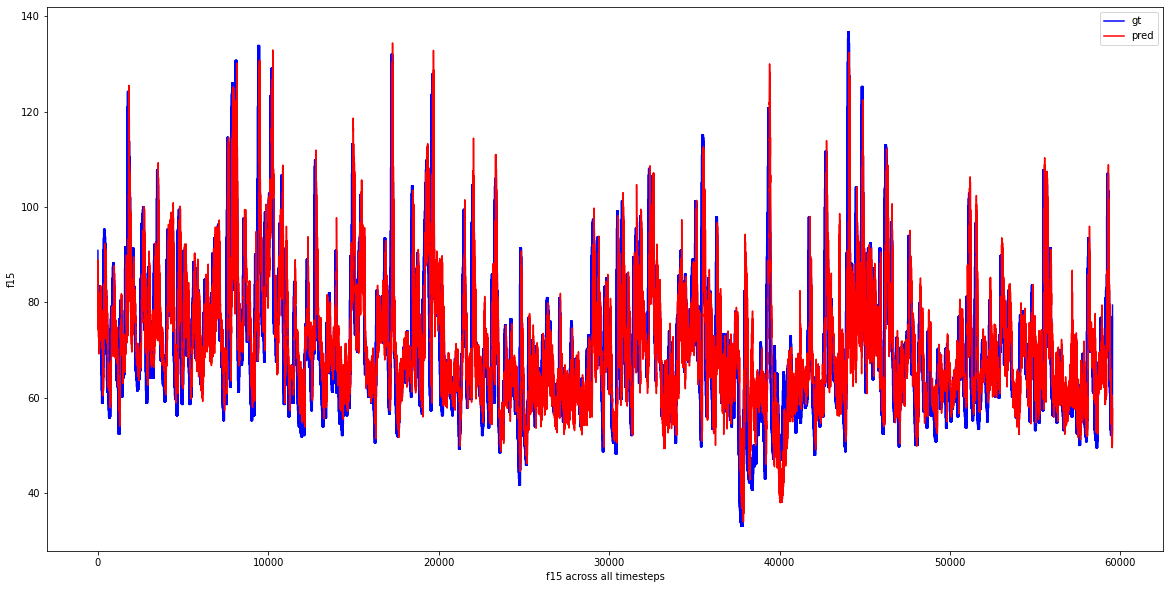

9.944786652049139


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,14], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,14],c='red', label="pred")

plt.legend()

plt.xlabel('f15 across all timesteps')

plt.ylabel('f15')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,14], pred.reshape(-1,pred.shape[-1])[:,14],squared=False))

Total rmse f16

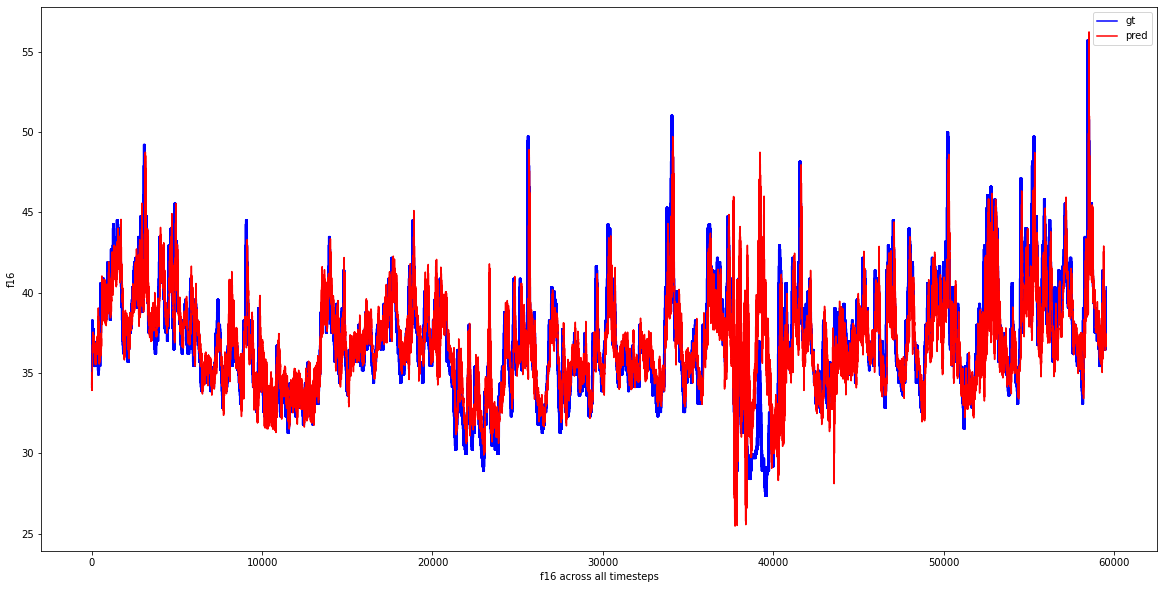

2.3847257533243806


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,15], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,15],c='red', label="pred")

plt.legend()

plt.xlabel('f16 across all timesteps')

plt.ylabel('f16')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,15], pred.reshape(-1,pred.shape[-1])[:,15],squared=False))

Total rmse f17

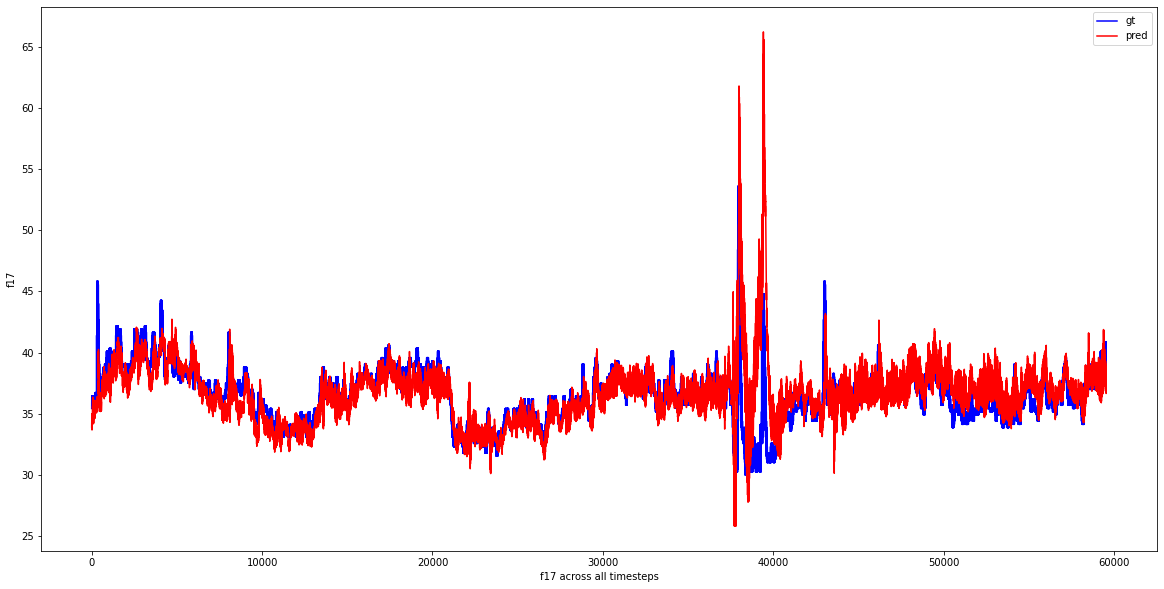

2.2704786210301076


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,16], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,16],c='red', label="pred")

plt.legend()

plt.xlabel('f17 across all timesteps')

plt.ylabel('f17')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,16], pred.reshape(-1,pred.shape[-1])[:,16],squared=False))

Total rmse f18

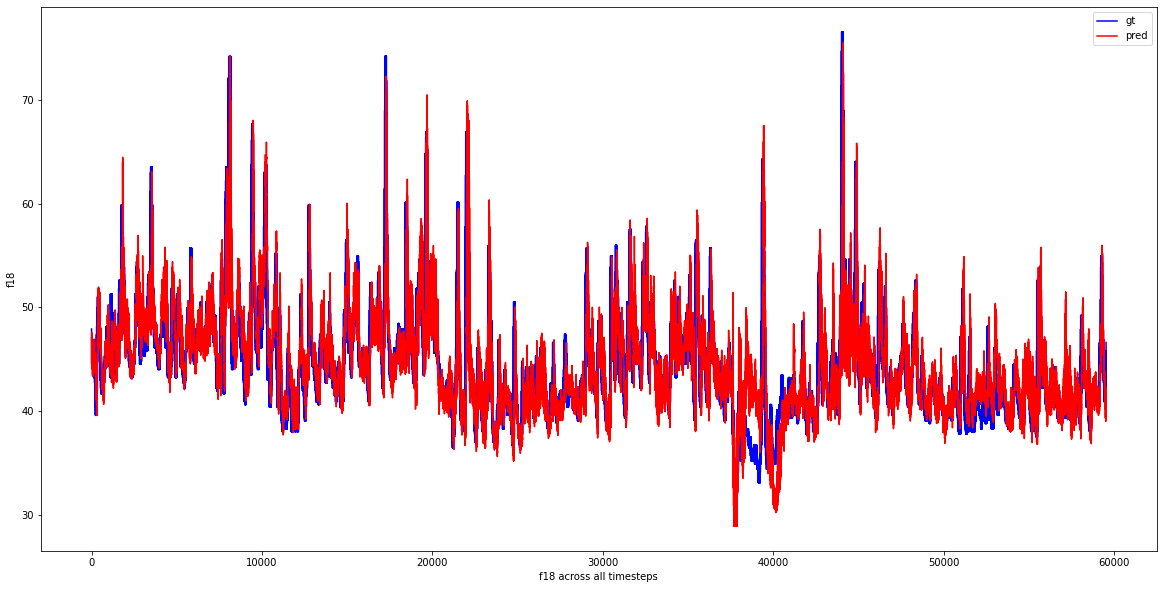

3.248560578466513


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,17], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,17],c='red', label="pred")

plt.legend()

plt.xlabel('f18 across all timesteps')

plt.ylabel('f18')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,17], pred.reshape(-1,pred.shape[-1])[:,17],squared=False))

Total rmse f19

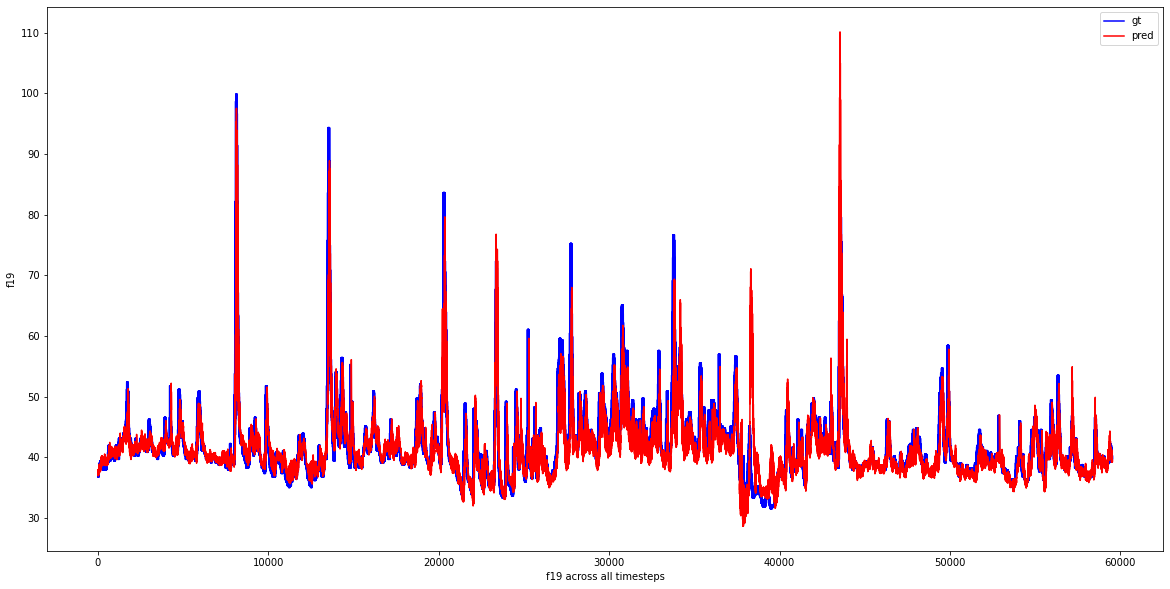

3.412433356982661


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,18], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,18],c='red', label="pred")

plt.legend()

plt.xlabel('f19 across all timesteps')

plt.ylabel('f19')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,18], pred.reshape(-1,pred.shape[-1])[:,18],squared=False))

Total rmse f20

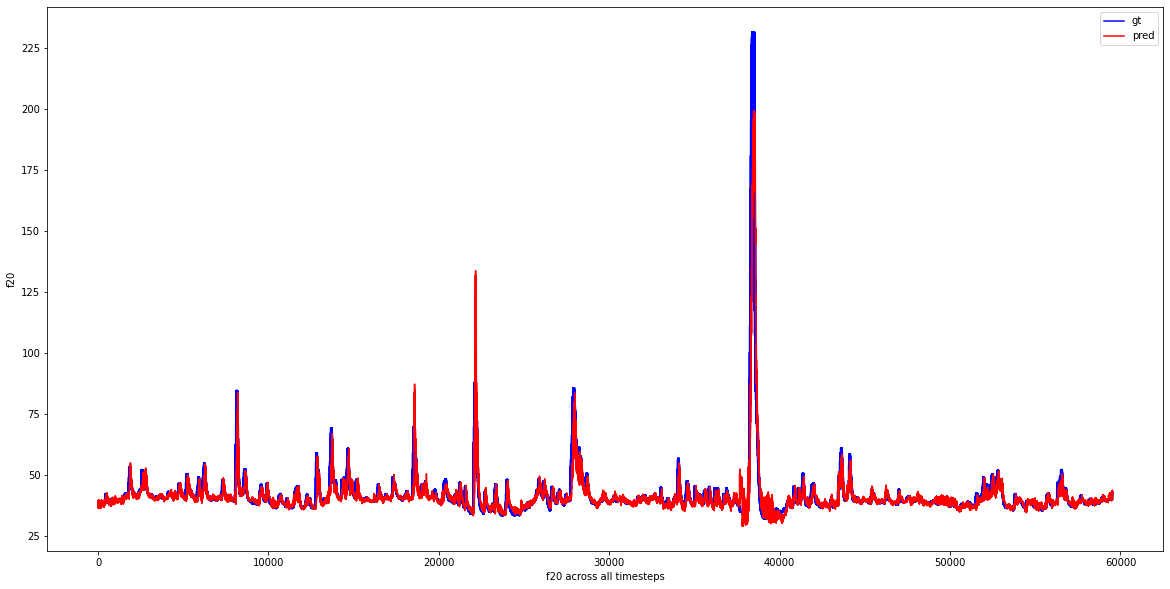

5.377178313158022


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,19], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,19],c='red', label="pred")

plt.legend()

plt.xlabel('f20 across all timesteps')

plt.ylabel('f20')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,19], pred.reshape(-1,pred.shape[-1])[:,19],squared=False))

Total rmse f21

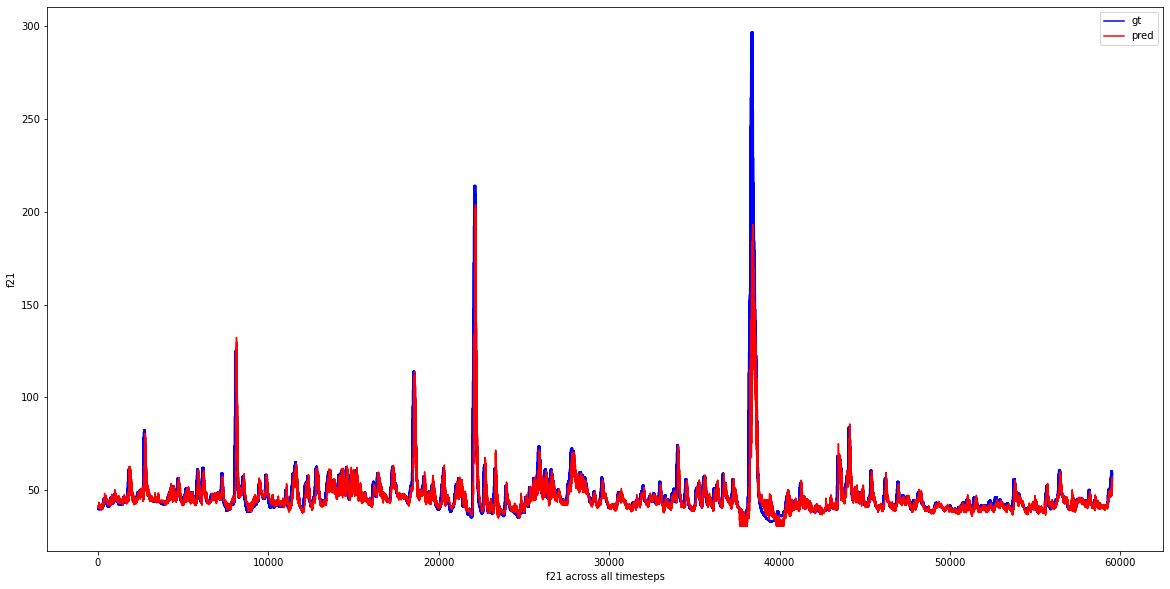

9.769498468972573


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,20], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,20],c='red', label="pred")

plt.legend()

plt.xlabel('f21 across all timesteps')

plt.ylabel('f21')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,20], pred.reshape(-1,pred.shape[-1])[:,20],squared=False))

Total rmse f22

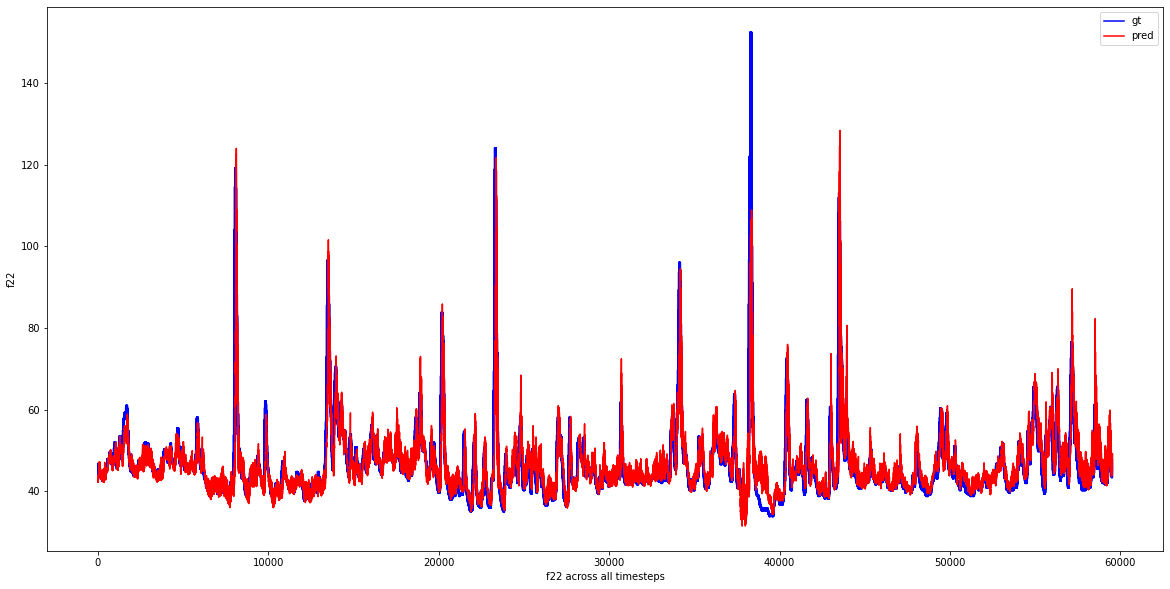

5.027993727951052


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,21], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,21],c='red', label="pred")

plt.legend()

plt.xlabel('f22 across all timesteps')

plt.ylabel('f22')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,21], pred.reshape(-1,pred.shape[-1])[:,21],squared=False))

Total rmse f23

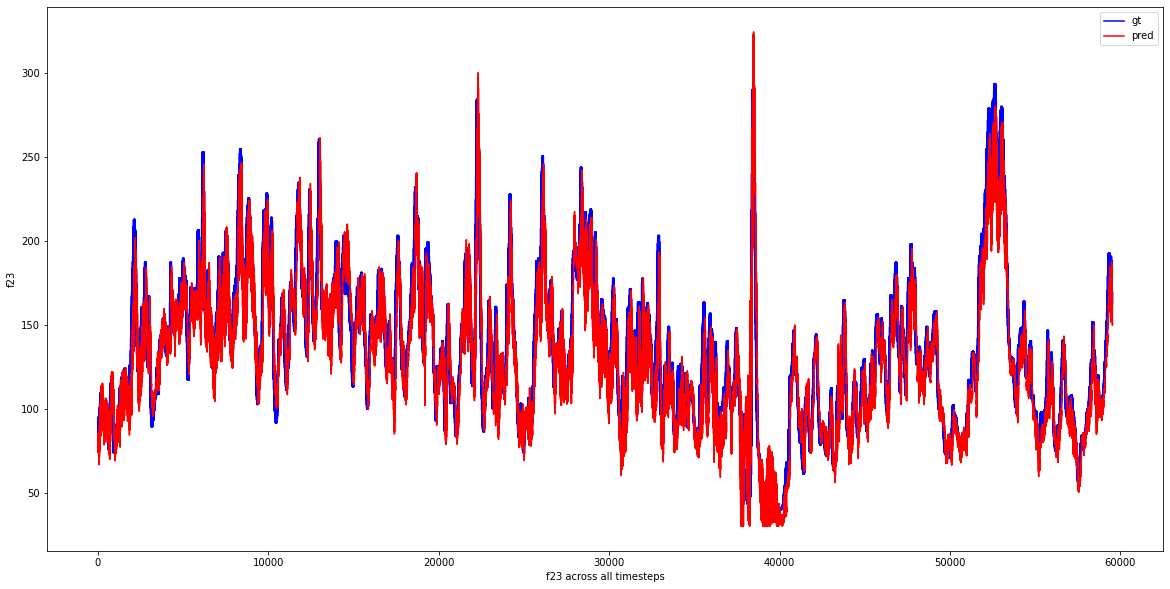

18.604574541967047


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,22], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,22],c='red', label="pred")

plt.legend()

plt.xlabel('f23 across all timesteps')

plt.ylabel('f23')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,22], pred.reshape(-1,pred.shape[-1])[:,22],squared=False))

Total rmse f24

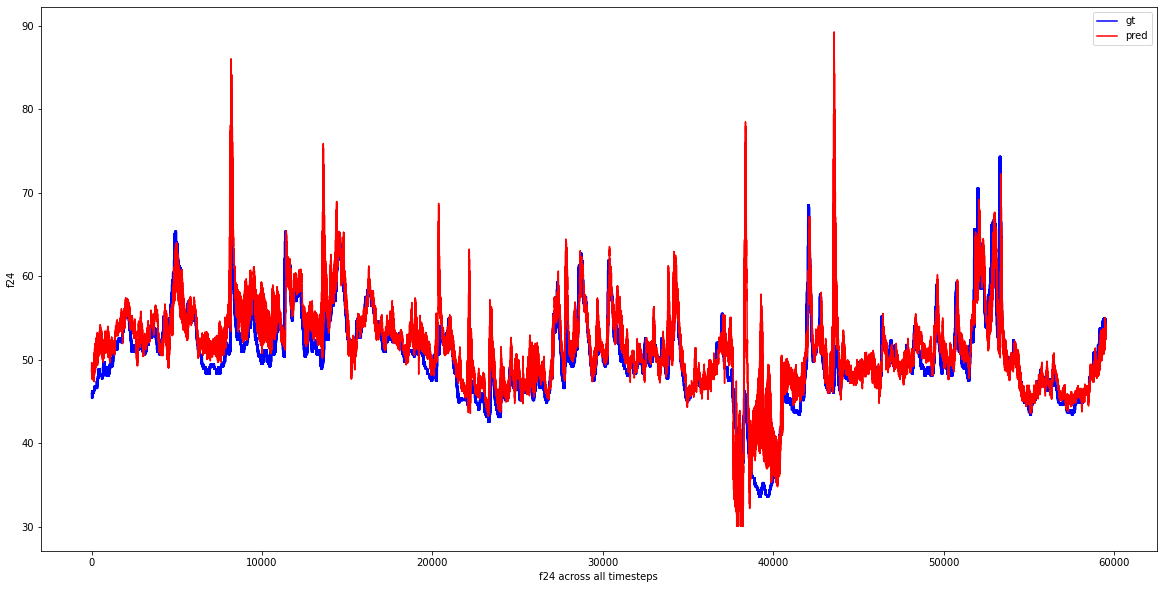

3.4853563798507916


In [ ]:
plt.figure(figsize=(20,10)) 

plt.plot(final_output_test.reshape(-1,final_output_test.shape[-1])[:,23], c='blue', label="gt")

plt.plot(pred.reshape(-1,pred.shape[-1])[:,23],c='red', label="pred")

plt.legend()

plt.xlabel('f24 across all timesteps')

plt.ylabel('f24')

plt.show()

print(mean_squared_error(final_output_test.reshape(-1,final_output_test.shape[-1])[:,23], pred.reshape(-1,pred.shape[-1])[:,23],squared=False))